In [1]:
import numpy as np
from matplotlib import pyplot
from collections import deque
import matplotlib as mpl

mpl.rcParams.update({'font.size': 14,
                     'figure.figsize': (17,10)
                    })

In [2]:
class BaseScenario(object):  
    def __init__(self):
        self.cases = [1]
        self.lockdowns = []
        self.remaining_lockdown = 0
        self.remaining_incubation = 0
    
    def simulate(self):
        for step in range(self.duration):
            self.cases.append(self.next(step, self.cases[-1]))
            
            # Update lockdown list if necessary
            if self.remaining_lockdown > 0 and (len(self.lockdowns) == 0 or "end" in self.lockdowns[-1]):
                self.lockdowns.append({"start": step})
            elif self.remaining_lockdown == 0 and len(self.lockdowns) > 0 and "end" not in self.lockdowns[-1]:
                self.lockdowns[-1]["end"] = step
    
    def plot(self):
        # Draw celebration markers
        for i, celebration in enumerate(self.celebrations):
            pyplot.plot([celebration, celebration],
                        [0, max(self.cases)],
                        color="red",
                        label="celebrations" if i == 0 else "")

        # Draw lockdown periods
        for i, lockdown in enumerate(self.lockdowns):
            pyplot.fill_between([lockdown["start"],
                                 lockdown["end"] if "end" in lockdown else self.duration],
                                 0, max(self.cases),
                                color = 'green', alpha = 0.1, label="lockdown" if i == 0 else "")

        pyplot.plot(range(len(self.cases)), self.cases, label="COVID-19 cases")
        pyplot.legend()
        pyplot.title("Lockdowns of {} days above {} cases, with {} celebrations and {} days of incubation".format(
                     self.lockdown_duration,
                     self.critical,
                     len(self.celebrations),
                     self.incubation_duration))
        pyplot.xlabel('days')
        pyplot.ylabel('COVID-19 positive cases')
        pyplot.show()

In [3]:
class Scenario(BaseScenario):
    def __init__(self,
                 lockdown_duration: int,
                 incubation_duration: int,
                 duration: int,
                 critical: int,
                 celebrations: list,
                 r0: dict):
        super(Scenario, self).__init__()
        self.lockdown_duration = lockdown_duration
        self.incubation_duration = incubation_duration
        self.duration = duration
        self.critical = critical
        self.celebrations = celebrations
        self.r0 = r0
        self.r0_history = deque(incubation_duration*[1], maxlen=incubation_duration)
                    
    def next(self, step:int, previous_infected:int):
        if self.remaining_lockdown > 0:
            r0 = self.r0["lockdown"]
            self.remaining_lockdown -= 1
        elif previous_infected > self.critical:
            r0 = self.r0["lockdown"]
            self.remaining_lockdown = self.lockdown_duration
        else:
            r0 = self.r0["regular"]

        if step in self.celebrations:
            r0 *= self.r0["high"]

        self.r0_history.append(r0)
        return self.r0_history.popleft()*previous_infected

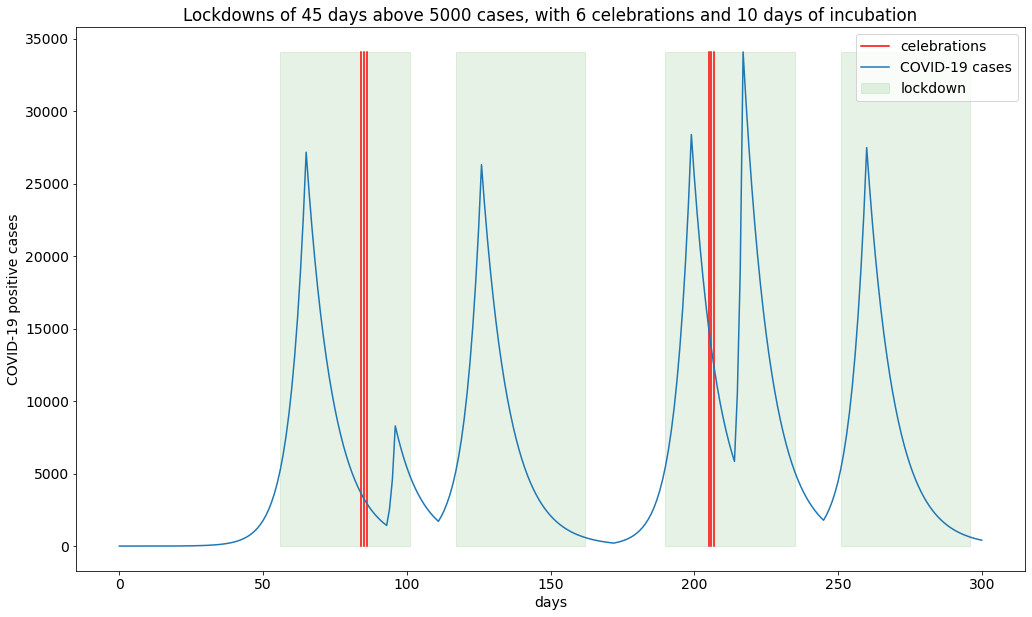

In [4]:
s = Scenario(
    lockdown_duration = 45,
    incubation_duration= 10,
    duration = 300,
    critical = 5000,
    celebrations = [
                    84, 85, 86,     # Celebration + lockdown
                    205, 206, 207  # Celebration but no lockdown
                   ], 
    r0 = {
        "regular": 1.2,
        "high": 2,
        "lockdown": 0.9,
    }
)
s.simulate()
s.plot()

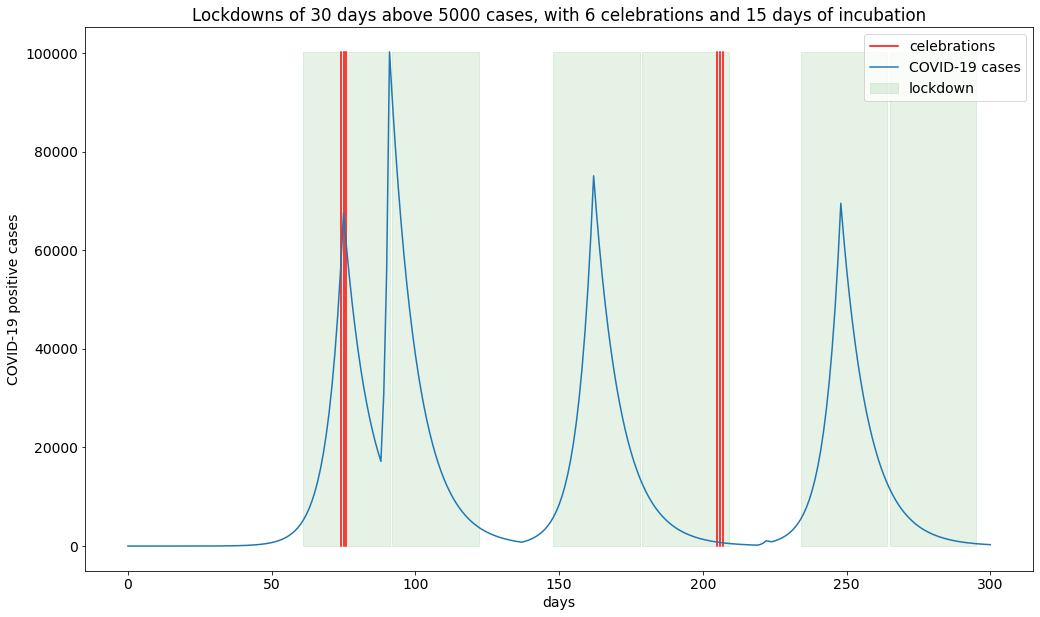

In [5]:
s = Scenario(
    lockdown_duration = 30,
    incubation_duration = 15,
    duration = 300,
    critical = 5000,
    celebrations = [
                    74, 75, 76,     # Celebration + lockdown
                    205, 206, 207   # Celebration but no lockdown
                   ], 
    r0 = {
        "regular": 1.2,
        "high": 2,
        "lockdown": 0.9,
    }
)
s.simulate()
s.plot()